<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
이전(online-learning-HDLSTM(Seasonal)-Sample1)과 다르게 scaling을 additive로 진행했다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [5]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [6]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [10]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x-div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        
        output = trend_output+season_output+div_factor
        
        return output,season_output,trend_output

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_527215/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [14]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [15]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [16]:
torch.manual_seed(42)

In [17]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [18]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 3.2646747275591927 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 3.5681693536217174 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 2.720860962739639 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 2.8494581873344846 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 3.033780229886536 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 2.3596805451527696 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 2.618636743809581 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 2.1468942589977518 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 1.813493991249897 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 2.2756022115698227 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 2.0926104295690413 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 2.283308063540131 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 1.747742410461903 %
Adjus

In [31]:
print(ss_list[26])
print(tr_list[0])

tensor([[[-0.1018]],

        [[-0.1018]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1020]],

        [[-0.1019]],

        [[-0.1017]],

        [[-0.1019]],

        [[-0.1020]],

        [[-0.1019]],

        [[-0.1018]],

        [[-0.1018]],

        [[-0.1018]],

        [[-0.1018]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1019]],

        [[-0.1020]],

        [[-0.1019]],

        [[-0.1018]],

        [[-0.1019]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[-0.2003]],

        [[-0.2060]],

        [[-0.2016]],

        [[-0.2009]],

        [[-0.2086]],

        [[-0.1957]],

        [[-0.1979]],

        [[-0.1996]],

        [[-0.1952]],

        [[-0.2025]],

        [[-0.2022]],

        [[-0

In [19]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.00859579831998758 %
SMAPE 0.003915965735671989 %
SMAPE 0.002848343194074232 %
SMAPE 0.005766220246925968 %
SMAPE 0.005712508003547612 %
SMAPE 0.009081355726351603 %
SMAPE 0.00645048538000026 %
SMAPE 0.004054222492811732 %
SMAPE 0.002891007278101654 %
SMAPE 0.004227681179315823 %
SMAPE 0.004756006524786471 %
SMAPE 0.005309445775679933 %
SMAPE 0.006328342702147438 %
SMAPE 0.002706998228184432 %
SMAPE 0.0021586886357454205 %
SMAPE 0.01462918697842497 %
SMAPE 0.014118543065137603 %
SMAPE 0.012410788443503407 %
SMAPE 0.009219088070707926 %
SMAPE 0.001504231948672441 %
SMAPE 0.005057406589571656 %
SMAPE 0.0009648692690689131 %
SMAPE 0.016983612362366785 %
SMAPE 0.010755408979775893 %
SMAPE 0.004417340989220975 %
SMAPE 0.010769800115895123 %
SMAPE 0.012885747599312937 %
SMAPE 0.010102433092185947 %
SMAPE 0.01739329813523227 %
SMAPE 0.023043153990101928 %
SMAPE 0.01671671633181404 %
SMAPE 0.0026502700859509787 %
SMAPE 0.003660158172280603 %
SMAPE 0.0022869540914598474 %
SMAPE 0.0040019

SMAPE 0.02116956920056623 %
SMAPE 0.004469566830778149 %
SMAPE 0.00874093210627791 %
SMAPE 0.008145228905561908 %
SMAPE 0.02842864902908104 %
SMAPE 0.02315632094166631 %
SMAPE 0.030163659673917213 %
SMAPE 0.0011122228569320214 %
SMAPE 0.004789677957852234 %
SMAPE 0.00795352353510026 %
SMAPE 0.005289158236564617 %
SMAPE 0.005902250088183791 %
SMAPE 0.005650738775443642 %
SMAPE 0.003339714561548135 %
SMAPE 0.00544796128746583 %
SMAPE 0.0033309002553778555 %
SMAPE 0.005195257711193335 %
SMAPE 0.0006584996598917314 %
SMAPE 0.002208027666043222 %
SMAPE 0.001436511408478225 %
SMAPE 0.0035717345930947886 %
SMAPE 0.0009165146654908084 %
SMAPE 0.0027205486914496646 %
SMAPE 0.0037595062381967637 %
SMAPE 0.001448399711989623 %
SMAPE 0.005507407092608219 %
SMAPE 0.001857817532595618 %
SMAPE 0.007410502008525555 %
SMAPE 0.006629609516039636 %
SMAPE 0.0031482328428040773 %
SMAPE 0.005463767088485838 %
SMAPE 0.0029982827874519558 %
SMAPE 0.0028652628741383523 %
SMAPE 0.003786025351452338 %
SMAPE 0.01

SMAPE 0.009305945146138583 %
SMAPE 0.0012435780414534747 %
SMAPE 0.008120186722095468 %
SMAPE 0.0015033720624444413 %
SMAPE 0.0009370944135866921 %
SMAPE 0.002208594804670838 %
SMAPE 0.003908229466475177 %
SMAPE 0.006197422421308829 %
SMAPE 0.0022792608899493416 %
SMAPE 0.00946952186976091 %
SMAPE 0.0017172936508131897 %
SMAPE 0.00435385454063919 %
SMAPE 0.007156197417373277 %
SMAPE 0.0012790562809499306 %
SMAPE 0.019061667659741488 %
SMAPE 0.004686309512635489 %
SMAPE 0.0008608013054924868 %
SMAPE 0.0014350498759156949 %
SMAPE 0.004580277034961 %
SMAPE 0.005959156271757138 %
SMAPE 0.001694263727017642 %
SMAPE 0.005500831444862797 %
SMAPE 0.0008481041586350102 %
SMAPE 0.0025247366543226235 %
SMAPE 0.002176645734152771 %
SMAPE 0.005753437365910941 %
SMAPE 0.0015733599099192477 %
SMAPE 0.0005761518243048158 %
SMAPE 0.0012865486380633229 %
SMAPE 0.001289761597291772 %
SMAPE 0.013264581340337147 %
SMAPE 0.006073025692472811 %
SMAPE 0.0027211552628045865 %
SMAPE 0.0036204723258137506 %
SMAP

SMAPE 0.003253496190225746 %
SMAPE 0.006012435314858067 %
SMAPE 0.009499069718060582 %
SMAPE 0.011783435578763601 %
SMAPE 0.0033523839380791283 %
SMAPE 0.013425380943544953 %
SMAPE 0.003498212363062691 %
SMAPE 0.0021922659785218457 %
SMAPE 0.022461818518877408 %
SMAPE 0.004947262096806071 %
SMAPE 0.018606292743641006 %
SMAPE 0.005267371921775066 %
SMAPE 0.003775043958057722 %
SMAPE 0.009463584884400689 %
SMAPE 0.0009492970174278524 %
SMAPE 0.0014240313191606901 %
SMAPE 0.0032188332334612824 %
SMAPE 0.001831355052843264 %
SMAPE 0.009922624708522676 %
SMAPE 0.003910375884458972 %
SMAPE 0.0034830193139896433 %
SMAPE 0.0013745493742476356 %
SMAPE 0.00398055771631789 %
SMAPE 0.006196723858721498 %
SMAPE 0.003206212989994128 %
SMAPE 0.005542575977870001 %
SMAPE 0.007464769830249907 %
SMAPE 0.0030691350966662867 %
SMAPE 0.004542962050706478 %
SMAPE 0.003489467608886798 %
SMAPE 0.002279014568784987 %
SMAPE 0.004281900268011896 %
SMAPE 0.0037148344391653154 %
SMAPE 0.011744237055552276 %
SMAPE 

SMAPE 0.012243092276207792 %
SMAPE 0.0025598007830467395 %
SMAPE 0.011197459104437257 %
SMAPE 0.005325843214222914 %
SMAPE 0.005919156546951854 %
SMAPE 0.0028949454202873426 %
SMAPE 0.001957054576024575 %
SMAPE 0.0063194757999553985 %
SMAPE 0.0043068037120690406 %
SMAPE 0.0029958249746186993 %
SMAPE 0.005209672630343221 %
SMAPE 0.0012734449399545156 %
SMAPE 0.00438409479869506 %
SMAPE 0.002082356884073988 %
SMAPE 0.005328855414504119 %
SMAPE 0.006062422562038705 %
SMAPE 0.012096708929519195 %
SMAPE 0.00195675372950177 %
SMAPE 0.0021703093886884517 %
SMAPE 0.004232185529360777 %
SMAPE 0.0040199601091330806 %
SMAPE 0.003312967653236853 %
SMAPE 0.0031824581394062075 %
SMAPE 0.009495861440086628 %
SMAPE 0.0029954955649031945 %
SMAPE 0.0013403973663912438 %
SMAPE 0.0033242216071300845 %
SMAPE 0.0031676699450287065 %
SMAPE 0.0021144731636013603 %
SMAPE 0.005220373637030207 %
SMAPE 0.005018005679517046 %
SMAPE 0.004141472124970846 %
SMAPE 0.001205423430292285 %
SMAPE 0.0020672297630994763 %
S

SMAPE 0.0066245766908537 %
SMAPE 0.00426556309218995 %
SMAPE 0.0030938500482662334 %
SMAPE 0.0011630773658453109 %
SMAPE 0.005299429816062684 %
SMAPE 0.0011776660938664918 %
SMAPE 0.003603687709329506 %
SMAPE 0.0017146225930773085 %
SMAPE 0.0021087171197393673 %
SMAPE 0.0023087034115931715 %
SMAPE 0.0022066022003173202 %
SMAPE 0.004209289165942209 %
SMAPE 0.009277422209805763 %
SMAPE 0.0025700499202230276 %
SMAPE 0.0011525827460161508 %
SMAPE 0.0008258349215424232 %
SMAPE 0.005622510306025674 %
SMAPE 0.0035297821183348788 %
SMAPE 0.0020243951559706375 %
SMAPE 0.0007559912943406744 %
SMAPE 0.010472672740945654 %
SMAPE 0.0009322645784095585 %
SMAPE 0.0039028410733408236 %
SMAPE 0.010144529868242103 %
SMAPE 0.0049687614076106 %
SMAPE 0.0017029709706264384 %
SMAPE 0.002631749154033969 %
SMAPE 0.003824990508292103 %
SMAPE 0.00047629033831952933 %
SMAPE 0.0013286971166621697 %
SMAPE 0.0023413137628551794 %
SMAPE 0.001263141350676733 %
SMAPE 0.0024352354138841292 %
SMAPE 0.0036173515063708805

SMAPE 0.0016152608187667281 %
SMAPE 0.0036946024036694784 %
SMAPE 0.006054378470821575 %
SMAPE 0.006566301448799549 %
SMAPE 0.0013523294442450151 %
SMAPE 0.0034272913286486077 %
SMAPE 0.001249638376805251 %
SMAPE 0.008702266772559142 %
SMAPE 0.008108848620310027 %
SMAPE 0.0010797692870312403 %
SMAPE 0.0030844987698728232 %
SMAPE 0.0008928170993272033 %
SMAPE 0.005789831068199192 %
SMAPE 0.002015833757035068 %
SMAPE 0.004410266708759991 %
SMAPE 0.00536211096164152 %
SMAPE 0.004020882960332983 %
SMAPE 0.002889614779689964 %
SMAPE 0.001738662739199981 %
SMAPE 0.010691765736396519 %
SMAPE 0.0014121360988781362 %
SMAPE 0.0043519307909321014 %
SMAPE 0.00607991028210364 %
SMAPE 0.008034478910730058 %
SMAPE 0.0036671594919397417 %
SMAPE 0.005877944571821558 %
SMAPE 0.0038940376066420868 %
SMAPE 0.004122891077656732 %
SMAPE 0.007745843533427887 %
SMAPE 0.003929066899161171 %
SMAPE 0.006657160161239516 %
SMAPE 0.001804989228837428 %
SMAPE 0.004104443416082404 %
SMAPE 0.006242200036695067 %
SMAPE

SMAPE 0.004444444930868485 %
SMAPE 0.003684487698237149 %
SMAPE 0.007858889259608759 %
SMAPE 0.002877050078630816 %
SMAPE 0.0032331493083006535 %
SMAPE 0.005608745414065197 %
SMAPE 0.005011012889994504 %
SMAPE 0.002002984440323985 %
SMAPE 0.0009593081649938995 %
SMAPE 0.005744129055486269 %
SMAPE 0.004066486979581896 %
SMAPE 0.0029070493554854693 %
SMAPE 0.0023302724488303284 %
SMAPE 0.0018914477309692757 %
SMAPE 0.0018098780242894461 %
SMAPE 0.007081020521468417 %
SMAPE 0.0036313942092647262 %
SMAPE 0.00804697797497056 %
SMAPE 0.013164461699147978 %
SMAPE 0.006432504831423103 %
SMAPE 0.020031776429718207 %
SMAPE 0.007551902429582924 %
SMAPE 0.005649319976555489 %
SMAPE 0.004027732496481917 %
SMAPE 0.0034143647712880916 %
SMAPE 0.01093220443709697 %
SMAPE 0.0017103742805488764 %
SMAPE 0.0035288828996726807 %
SMAPE 0.003980416357933336 %
SMAPE 0.0019678393579170006 %
SMAPE 0.0008596330185355326 %
SMAPE 0.0034181121694416556 %
SMAPE 0.006726141818035103 %
SMAPE 0.001215807868675256 %
SMA

SMAPE 0.0028344172272056767 %
SMAPE 0.0032123448464176363 %
SMAPE 0.0006938119203709903 %
SMAPE 0.0015930599021061196 %
SMAPE 0.016463736521785677 %
SMAPE 0.001458491621995961 %
SMAPE 0.004035687525458798 %
SMAPE 0.0023949565134557815 %
SMAPE 0.00717317896388181 %
SMAPE 0.007330468714911832 %
SMAPE 0.003861827779758187 %
SMAPE 0.0029025800249087297 %
SMAPE 0.0032730289958351477 %
SMAPE 0.004632070978260572 %
SMAPE 0.00562738994335632 %
SMAPE 0.0015307874593872839 %
SMAPE 0.003724258608144737 %
SMAPE 0.0009701856132267039 %
SMAPE 0.005971334326204669 %
SMAPE 0.006698185464983907 %
SMAPE 0.0020042796220423043 %
SMAPE 0.005237792128177432 %
SMAPE 0.005120326662677144 %
SMAPE 0.005293066904840771 %
SMAPE 0.002044085104671467 %
SMAPE 0.0009762230197196686 %
SMAPE 0.008154311915944845 %
SMAPE 0.005729273738552365 %
SMAPE 0.005060386670834305 %
SMAPE 0.005408505683362819 %
SMAPE 0.0012486873022083955 %
SMAPE 0.0035683096005527663 %
SMAPE 0.004845493540415191 %
SMAPE 0.0039412775742491135 %
SM

SMAPE 0.0011522895980817793 %
SMAPE 0.0037875322043419146 %
SMAPE 0.0023310622652275015 %
SMAPE 0.01235043953187187 %
SMAPE 0.003908189342283208 %
SMAPE 0.014362832183763885 %
SMAPE 0.0008815041796310653 %
SMAPE 0.008283607632336043 %
SMAPE 0.005854433063220199 %
SMAPE 0.0014310722712878032 %
SMAPE 0.0007660316798308031 %
SMAPE 0.0045069434303357525 %
SMAPE 0.018115095657378788 %
SMAPE 0.0015151342853982896 %
SMAPE 0.0006492073959805111 %
SMAPE 0.0013155961688653406 %
SMAPE 0.017753787383952613 %
SMAPE 0.013274090862104517 %
SMAPE 0.004379925727761247 %
SMAPE 0.003344616517409804 %
SMAPE 0.004298626189438437 %
SMAPE 0.008317203663352757 %
SMAPE 0.01255472041245298 %
SMAPE 0.0007301210772823197 %
SMAPE 0.0035152130270148523 %
SMAPE 0.005658141506316383 %
SMAPE 0.012123047969879508 %
SMAPE 0.004967661355813391 %
SMAPE 0.004862959882260043 %
SMAPE 0.0034593889930363275 %
SMAPE 0.020482382431822543 %
SMAPE 0.0023723057734059694 %
SMAPE 0.0174757053406438 %
SMAPE 0.009515936088064336 %
SMAP

SMAPE 0.0011056251551480045 %
SMAPE 0.005119460616725746 %
SMAPE 0.004761985023492343 %
SMAPE 0.0012368655870886869 %
SMAPE 0.003599282142772609 %
SMAPE 0.0033072573593813104 %
SMAPE 0.013198294214909369 %
SMAPE 0.0012162817584595587 %
SMAPE 0.015807778679032936 %
SMAPE 0.010165211238792438 %
SMAPE 0.0012758533866872313 %
SMAPE 0.001401018901432849 %
SMAPE 0.005323710198467779 %
SMAPE 0.006594842647878352 %
SMAPE 0.0036891820064397507 %
SMAPE 0.0015211675594031249 %
SMAPE 0.0019420366322435711 %
SMAPE 0.008483041783222234 %
SMAPE 0.0017862258291643231 %
SMAPE 0.004470102296792788 %
SMAPE 0.006265933140042534 %
SMAPE 0.001057280994544385 %
SMAPE 0.004269383548283656 %
SMAPE 0.0015714452166264439 %
SMAPE 0.00203349430454125 %
SMAPE 0.005549364091848474 %
SMAPE 0.003285026691855819 %
SMAPE 0.002090160313571232 %
SMAPE 0.0022995908806393572 %
SMAPE 0.005382095341587956 %
SMAPE 0.005035852375272043 %
SMAPE 0.0073233102875747145 %
SMAPE 0.0013823865563935556 %
SMAPE 0.0010017763987661965 %
S

SMAPE 0.0015627937468707387 %
SMAPE 0.0024782045851452494 %
SMAPE 0.015905270303449015 %
SMAPE 0.012290935181738405 %
SMAPE 0.0044646554340488365 %
SMAPE 0.010699119369249388 %
SMAPE 0.008590800420563482 %
SMAPE 0.007028695162432541 %
SMAPE 0.002551553476166646 %
SMAPE 0.004347504012542913 %
SMAPE 0.0018246021955121705 %
SMAPE 0.0011962343214975135 %
SMAPE 0.008493267759639878 %
SMAPE 0.007602712895504737 %
SMAPE 0.011609349879904585 %
SMAPE 0.004625113353398547 %
SMAPE 0.003418988217319452 %
SMAPE 0.009856213852557971 %
SMAPE 0.008541024963193422 %
SMAPE 0.0037290831620495624 %
SMAPE 0.010827299348420638 %
SMAPE 0.008555089542717553 %
SMAPE 0.013286699272356374 %
SMAPE 0.008471224782091724 %
SMAPE 0.008432308718738568 %
SMAPE 0.022558947906809124 %
SMAPE 0.0017868217342709156 %
SMAPE 0.01249141945061183 %
SMAPE 0.005391256717871329 %
SMAPE 0.0033358925530819756 %
SMAPE 0.004381530224513597 %
SMAPE 0.0033940007774617698 %
SMAPE 0.004201517759156559 %
SMAPE 0.003776501485958761 %
SMAPE 

SMAPE 0.004390544320671097 %
SMAPE 0.01736152903652055 %
SMAPE 0.001306428119875136 %
SMAPE 0.02240519507108729 %
SMAPE 0.0014658423950919541 %
SMAPE 0.008355695018735787 %
SMAPE 0.024542305240238704 %
SMAPE 0.00796691765185642 %
SMAPE 0.0045966835059303435 %
SMAPE 0.004563187834833116 %
SMAPE 0.0016404368986400184 %
SMAPE 0.01178967442240264 %
SMAPE 0.00882831521394678 %
SMAPE 0.0051203439757046 %
SMAPE 0.004522232868964693 %
SMAPE 0.00889064075471424 %
SMAPE 0.003675226909336971 %
SMAPE 0.001374954606070844 %
SMAPE 0.00812190514784561 %
SMAPE 0.01206859837654406 %
SMAPE 0.00169212674789776 %
SMAPE 0.018730786318599257 %
SMAPE 0.001997129765044292 %
SMAPE 0.008038399709676014 %
SMAPE 0.013502857521984879 %
SMAPE 0.001547815084741444 %
SMAPE 0.014851307295828066 %
SMAPE 0.00905214341300109 %
SMAPE 0.0031964870132128453 %
SMAPE 0.00127757968766673 %
SMAPE 0.01688271440605149 %
SMAPE 0.003878923167235371 %
SMAPE 0.006414563222278957 %
SMAPE 0.013039183395321174 %
SMAPE 0.0007582334805604

SMAPE 0.0037991027662727106 %
SMAPE 0.0023905805174990746 %
SMAPE 0.006436893300289626 %
SMAPE 0.007677338330097427 %
SMAPE 0.0029342432817145436 %
SMAPE 0.008713722923829437 %
SMAPE 0.0018046118637755626 %
SMAPE 0.004789436818327886 %
SMAPE 0.004902015037629326 %
SMAPE 0.011326285729182928 %
SMAPE 0.01049655675913641 %
SMAPE 0.014705216611844207 %
SMAPE 0.009120287757696133 %
SMAPE 0.04274426195533465 %
SMAPE 0.007153427155117242 %
SMAPE 0.011475700070661787 %
SMAPE 0.0024385159654158883 %
SMAPE 0.005254329616263931 %
SMAPE 0.0018656269589882868 %
SMAPE 0.001994155472800685 %
SMAPE 0.008978856942121638 %
SMAPE 0.006294464847883319 %
SMAPE 0.004035380433606406 %
SMAPE 0.004900465208478977 %
SMAPE 0.013013996919085004 %
SMAPE 0.014132353235481787 %
SMAPE 0.003791719405256799 %
SMAPE 0.003910830589553882 %
SMAPE 0.0031348904482726425 %
SMAPE 0.022792378979033856 %
SMAPE 0.011751264957212015 %
SMAPE 0.0016541729231676072 %
SMAPE 0.013660448386417556 %
SMAPE 0.0051855276768719705 %
SMAPE 0

SMAPE 0.008149126963019171 %
SMAPE 0.004807600168305726 %
SMAPE 0.00891529962152049 %
SMAPE 0.010719880321829578 %
SMAPE 0.007511381883716695 %
SMAPE 0.01264422416059574 %
SMAPE 0.010342237564998413 %
SMAPE 0.005938125968668828 %
SMAPE 0.005071268317301758 %
SMAPE 0.003928688762997012 %
SMAPE 0.004008747504485655 %
SMAPE 0.0055467770329755695 %
SMAPE 0.0065906940929920665 %
SMAPE 0.0025363788207641846 %
SMAPE 0.008183309185767484 %
SMAPE 0.007908646591801016 %
SMAPE 0.008831479418404342 %
SMAPE 0.015305715771170016 %
SMAPE 0.018982797529417894 %
SMAPE 0.008304983840211833 %
SMAPE 0.002044569814223962 %
SMAPE 0.003200663227289624 %
SMAPE 0.002645251204057786 %
SMAPE 0.005808758772445799 %
SMAPE 0.004387415867839195 %
SMAPE 0.0022716918195087032 %
SMAPE 0.0022969387835019006 %
SMAPE 0.007655742120789455 %
SMAPE 0.0014117470250738506 %
SMAPE 0.004839954119333356 %
SMAPE 0.007660033946535805 %
SMAPE 0.0066330919055417326 %
SMAPE 0.008257246955110986 %
SMAPE 0.01539320566234892 %
SMAPE 0.00

SMAPE 0.016006612575552026 %
SMAPE 0.002893222306795451 %
SMAPE 0.004178941264910918 %
SMAPE 0.0066160731632862735 %
SMAPE 0.013146593056944766 %
SMAPE 0.0011217534080003588 %
SMAPE 0.0018423581917090814 %
SMAPE 0.0018808260183647008 %
SMAPE 0.01756384228627894 %
SMAPE 0.005074647989161463 %
SMAPE 0.004062713801573636 %
SMAPE 0.0011987023208632763 %
SMAPE 0.015619843008337853 %
SMAPE 0.029468071861970202 %
SMAPE 0.011593066640955385 %
SMAPE 0.001982658602059928 %
SMAPE 0.009357360444212759 %
SMAPE 0.0021432351541079697 %
SMAPE 0.0020452722046115923 %
SMAPE 0.008716207546399346 %
SMAPE 0.017527474104014118 %
SMAPE 0.008500910723796551 %
SMAPE 0.006671176124513067 %
SMAPE 0.002273279411525664 %
SMAPE 0.010920322740986421 %
SMAPE 0.0038842683907205355 %
SMAPE 0.001383797733851111 %
SMAPE 0.004056729326350705 %
SMAPE 0.006904086448230374 %
SMAPE 0.005780608744998972 %
SMAPE 0.007642852030642189 %
SMAPE 0.008859378919211736 %
SMAPE 0.0036760066029017935 %
SMAPE 0.0058100137824226294 %
SMAPE

SMAPE 0.003709360454166699 %
SMAPE 0.004403841787109286 %
SMAPE 0.005363725905191075 %
SMAPE 0.0021378961197342505 %
SMAPE 0.007512543753875888 %
SMAPE 0.009036696097808772 %
SMAPE 0.0032363710993195127 %
SMAPE 0.005094701978663352 %
SMAPE 0.006240022725350513 %
SMAPE 0.0167119544067873 %
SMAPE 0.009948421688534381 %
SMAPE 0.02265610629689263 %
SMAPE 0.015123638337286138 %
SMAPE 0.012319691923664777 %
SMAPE 0.00986151122793899 %
SMAPE 0.006004917025620671 %
SMAPE 0.012811024201937473 %
SMAPE 0.005905254400204285 %
SMAPE 0.003474013563391054 %
SMAPE 0.007702338820763543 %
SMAPE 0.002723156774891322 %
SMAPE 0.003115540229941871 %
SMAPE 0.0045069511993460765 %
SMAPE 0.005412368131260337 %
SMAPE 0.00422141705530521 %
SMAPE 0.002875628611718639 %
SMAPE 0.006175768357849165 %
SMAPE 0.0028173564045914645 %
SMAPE 0.0030664109787892357 %
SMAPE 0.005137494366863393 %
SMAPE 0.00576557437517522 %
SMAPE 0.003556273097643725 %
SMAPE 0.004758673427659232 %
SMAPE 0.004062308730411246 %
SMAPE 0.0020671

SMAPE 0.009678960357518918 %
SMAPE 0.003785811150123664 %
SMAPE 0.002719062561851615 %
SMAPE 0.06929484635907102 %
SMAPE 0.028062703898342537 %
SMAPE 0.01810331697197398 %
SMAPE 0.009046182134696323 %
SMAPE 0.01118354638265373 %
SMAPE 0.026029806012559217 %
SMAPE 0.05519746222955745 %
SMAPE 0.030681735669361384 %
SMAPE 0.022094232590006868 %
SMAPE 0.004986419339672921 %
SMAPE 0.011346467791099712 %
SMAPE 0.02236689350343113 %
SMAPE 0.03597466109557956 %
SMAPE 0.11899066639807644 %
SMAPE 0.005498211295645206 %
SMAPE 0.010742686228468301 %
SMAPE 0.00837897120666753 %
SMAPE 0.018392655550599102 %
SMAPE 0.004002390430514424 %
SMAPE 0.024003089713801273 %
SMAPE 0.006559822211556821 %
SMAPE 0.007810853970113385 %
SMAPE 0.008853807361724364 %
SMAPE 0.04189339377006718 %
SMAPE 0.006107500635152975 %
SMAPE 0.029496637758938956 %
SMAPE 0.011507961253812482 %
SMAPE 0.0016750463147872095 %
SMAPE 0.004857522820088889 %
SMAPE 0.03354191526489103 %
SMAPE 0.031238036223527384 %
SMAPE 0.004258820151790

SMAPE 0.5803678113152273 %
SMAPE 0.21154292519895537 %
SMAPE 0.22405572878142266 %
SMAPE 0.011920391408004605 %
SMAPE 0.014395388087791615 %
SMAPE 0.29923319442355023 %
SMAPE 0.25217234209958406 %
SMAPE 0.060947169820792624 %
SMAPE 0.7605466181412339 %
SMAPE 1.3714250400662422 %
SMAPE 0.7145744009649206 %
SMAPE 0.02730106203536309 %
SMAPE 0.011342216001082761 %
SMAPE 0.21195657960538483 %
SMAPE 0.3591650533629718 %
SMAPE 0.7019573564175516 %
SMAPE 0.054634325913298205 %
SMAPE 0.49769465578719974 %
SMAPE 0.146125160083443 %
SMAPE 0.14174264162920736 %
SMAPE 0.3271623513974191 %
SMAPE 0.03411553818898483 %
SMAPE 0.4735271716490388 %
SMAPE 0.10478282185601984 %
SMAPE 0.12211510720476326 %
SMAPE 0.06466610135547057 %
SMAPE 0.16057173655121915 %
SMAPE 0.22569051624850545 %
SMAPE 0.5386354327201843 %
SMAPE 0.014520825469503508 %
SMAPE 0.09762887935858089 %
SMAPE 0.03679545482282265 %
SMAPE 0.032943150939331645 %
SMAPE 0.08382068986225022 %
SMAPE 0.26165948070047307 %
SMAPE 0.1356448817050477

SMAPE 0.024701090135181403 %
SMAPE 0.01524188400287585 %
SMAPE 0.011678062576990555 %
SMAPE 0.001943317950960477 %
SMAPE 0.0064925931557127115 %
SMAPE 0.020213980409920396 %
SMAPE 0.01932099816416155 %
SMAPE 0.03677958836237849 %
SMAPE 0.028683225811647617 %
SMAPE 0.04340674074740036 %
SMAPE 0.0025470742492359477 %
SMAPE 0.0011239916836984776 %
SMAPE 0.026868973067990964 %
SMAPE 0.01750254490834635 %
SMAPE 0.0035739136627910284 %
SMAPE 0.0813005473576709 %
SMAPE 0.0071702500554238205 %
SMAPE 0.011834893830112492 %
SMAPE 0.06766291919268497 %
SMAPE 0.04206845407273363 %
SMAPE 0.010098506666878393 %
SMAPE 0.005571164917078875 %
SMAPE 0.00860228950749331 %
SMAPE 0.017272537767468066 %
SMAPE 0.01594528511540716 %
SMAPE 0.002658910035052031 %
SMAPE 0.007335182560048282 %
SMAPE 0.034003305560929675 %
SMAPE 0.010982903149667322 %
SMAPE 0.06205824039448516 %
SMAPE 0.007986799848396231 %
SMAPE 0.0203118155683768 %
SMAPE 0.05561000704182106 %
SMAPE 0.0057743822273721435 %
SMAPE 0.050211500786474

SMAPE 0.00769142877976492 %
SMAPE 0.014959356969427517 %
SMAPE 0.004619306627802189 %
SMAPE 0.03123117902447348 %
SMAPE 0.011981481637633351 %
SMAPE 0.014877220922471679 %
SMAPE 0.016132247639284003 %
SMAPE 0.010420920175846504 %
SMAPE 0.13763106725582475 %
SMAPE 0.0015677842759203033 %
SMAPE 0.06292059779457304 %
SMAPE 0.020841388559034613 %
SMAPE 0.022449971090125587 %
SMAPE 0.01730018113642018 %
SMAPE 0.045891667754517584 %
SMAPE 0.002487235262208287 %
SMAPE 0.019012508365221947 %
SMAPE 0.00202608390009118 %
SMAPE 0.004646805392440001 %
SMAPE 0.012420576163776786 %
SMAPE 0.003277107235476251 %
SMAPE 0.01685202840175748 %
SMAPE 0.012298920282432846 %
SMAPE 0.019034639604399217 %
SMAPE 0.0025375769282334204 %
SMAPE 0.003533247749004431 %
SMAPE 0.013314366742640969 %
SMAPE 0.03741080945201247 %
SMAPE 0.005086386885977845 %
SMAPE 0.0025826317149721945 %
SMAPE 0.0024687303712340736 %
SMAPE 0.07158035427687537 %
SMAPE 0.011863413849113158 %
SMAPE 0.0101551125410424 %
SMAPE 0.0047391555169

SMAPE 0.017495383913342266 %
SMAPE 0.00981405884834885 %
SMAPE 0.00619462642362123 %
SMAPE 0.0016372184014556979 %
SMAPE 0.018966766146149894 %
SMAPE 0.014139232964581085 %
SMAPE 0.011650649011215819 %
SMAPE 0.01192577310104781 %
SMAPE 0.008268342596096545 %
SMAPE 0.00873404427454716 %
SMAPE 0.007834640282290195 %
SMAPE 0.00399080595354917 %
SMAPE 0.027037712960918725 %
SMAPE 0.003584715523061277 %
SMAPE 0.002468764567446158 %
SMAPE 0.00459678397659502 %
SMAPE 0.00662352786278575 %
SMAPE 0.040448572994435494 %
SMAPE 0.007362818860542575 %
SMAPE 0.004086462877012309 %
SMAPE 0.003949523448653736 %
SMAPE 0.005223397350619052 %
SMAPE 0.037167552244341096 %
SMAPE 0.010150364798789724 %
SMAPE 0.008868934285345631 %
SMAPE 0.007077899641330987 %
SMAPE 0.030579461552918023 %
SMAPE 0.02734771261316382 %
SMAPE 0.012330926319464197 %
SMAPE 0.005278656290784056 %
SMAPE 0.0017422569584937264 %
SMAPE 0.01806768930623548 %
SMAPE 0.011161101590971612 %
SMAPE 0.024110258600558154 %
SMAPE 0.0206539858065

SMAPE 0.0037584213871753036 %
SMAPE 0.0045929293588642395 %
SMAPE 0.003681793633347752 %
SMAPE 0.005425381137051488 %
SMAPE 0.011082408758426254 %
SMAPE 0.0744787009934953 %
SMAPE 0.006668422262933405 %
SMAPE 0.018700577722228218 %
SMAPE 0.0034512735507519214 %
SMAPE 0.04436475090182057 %
SMAPE 0.0164332230691997 %
SMAPE 0.08330192326062047 %
SMAPE 0.007207643215195958 %
SMAPE 0.007357393849446226 %
SMAPE 0.0010795889252221968 %
SMAPE 0.04480953788825559 %
SMAPE 0.026407744846551395 %
SMAPE 0.041288596794970545 %
SMAPE 0.001013127066130437 %
SMAPE 0.0024582262544114997 %
SMAPE 0.002820762800894272 %
SMAPE 0.009039830277743022 %
SMAPE 0.001129288833496389 %
SMAPE 0.013724603814907255 %
SMAPE 0.018586949656850038 %
SMAPE 0.0039038695995827766 %
SMAPE 0.0057822344505780165 %
SMAPE 0.007096373512467835 %
SMAPE 0.015049524452024343 %
SMAPE 0.01714980009080591 %
SMAPE 0.010936295208210822 %
SMAPE 0.0025977181172152086 %
SMAPE 0.009099447774673308 %
SMAPE 0.010921889249310368 %
SMAPE 0.004030

SMAPE 0.008898012044703307 %
SMAPE 0.001247065899384836 %
SMAPE 0.020346513557932155 %
SMAPE 0.01602887904311956 %
SMAPE 0.0031081348967632034 %
SMAPE 0.014232293412447916 %
SMAPE 0.0019756119271931993 %
SMAPE 0.014434120883329626 %
SMAPE 0.05440477968625145 %
SMAPE 0.02377684150405912 %
SMAPE 0.07338902829815197 %
SMAPE 0.020135117399604496 %
SMAPE 0.04733024022090149 %
SMAPE 0.016649317581581613 %
SMAPE 0.01209439864483386 %
SMAPE 0.023989499963704475 %
SMAPE 0.009670503580707646 %
SMAPE 0.0016734479345359432 %
SMAPE 0.027747985310185186 %
SMAPE 0.030623807737867992 %
SMAPE 0.015061499961291247 %
SMAPE 0.07548243315068248 %
SMAPE 0.01996409479090744 %
SMAPE 0.02509472968506543 %
SMAPE 0.04148899860268784 %
SMAPE 0.02423376522790477 %
SMAPE 0.002228586897928153 %
SMAPE 0.07268813815949215 %
SMAPE 0.012523254514064773 %
SMAPE 0.0641565019400332 %
SMAPE 0.050744825378274065 %
SMAPE 0.003369095765151542 %
SMAPE 0.011682806294075476 %
SMAPE 0.04587980588291174 %
SMAPE 0.000877985633977118

SMAPE 0.10605988798761246 %
SMAPE 0.019597483745265265 %
SMAPE 0.005506152906718853 %
SMAPE 0.001776890597000147 %
SMAPE 0.012678868953841516 %
SMAPE 0.004435418571247851 %
SMAPE 0.010012003385384105 %
SMAPE 0.0029337075685020864 %
SMAPE 0.006314107231332855 %
SMAPE 0.005712610025170761 %
SMAPE 0.001147561579387002 %
SMAPE 0.002851047065092871 %
SMAPE 0.004599828270158923 %
SMAPE 0.0009496633406413935 %
SMAPE 0.0011917562004697402 %
SMAPE 0.004108197257210122 %
SMAPE 0.008732032353520935 %
SMAPE 0.002621047297296286 %
SMAPE 0.038098129355745414 %
SMAPE 0.01792290802882235 %
SMAPE 0.014973918915273998 %
SMAPE 0.004316337880034382 %
SMAPE 0.03650912076388835 %
SMAPE 0.017672777161472197 %
SMAPE 0.04718395344517745 %
SMAPE 0.0018755030629407088 %
SMAPE 0.0013820254701215617 %
SMAPE 0.02400584676868789 %
SMAPE 0.02348523383913914 %
SMAPE 0.007319014056243133 %
SMAPE 0.0015183608130016069 %
SMAPE 0.01902898425305466 %
SMAPE 0.0383879942427825 %
SMAPE 0.04229199595847888 %
SMAPE 0.0579819442

SMAPE 0.04896067519165114 %
SMAPE 0.02486306007085659 %
SMAPE 0.05308370948961283 %
SMAPE 0.05989912549483734 %
SMAPE 0.017422433059721243 %
SMAPE 0.0012927304804293271 %
SMAPE 0.04962918655081694 %
SMAPE 0.007833636999812654 %
SMAPE 0.05680467173897341 %
SMAPE 0.04779907237127645 %
SMAPE 0.036124513354764076 %
SMAPE 0.034092891189175134 %
SMAPE 0.057644203817332595 %
SMAPE 0.008084029820338401 %
SMAPE 0.01908845644289414 %
SMAPE 0.0037074736592259683 %
SMAPE 0.0008637861544542602 %
SMAPE 0.04640694773888754 %
SMAPE 0.011122444424287892 %
SMAPE 0.04589237082245745 %
SMAPE 0.004680475524722283 %
SMAPE 0.01681732549596404 %
SMAPE 0.03575784761954992 %
SMAPE 0.015452748394437776 %
SMAPE 0.007164733427572401 %
SMAPE 0.0007822523660934167 %
SMAPE 0.0035820131052020088 %
SMAPE 0.013496743309943326 %
SMAPE 0.008272459417355549 %
SMAPE 0.0027556916576259027 %
SMAPE 0.009125413531954507 %
SMAPE 0.010010464989903767 %
SMAPE 0.008033321337862276 %
SMAPE 0.005626932216387104 %
SMAPE 0.001350125369

SMAPE 0.0030408043414524855 %
SMAPE 0.0029328914818336216 %
SMAPE 0.004552030565434961 %
SMAPE 0.008634223714508948 %
SMAPE 0.00547105390046454 %
SMAPE 0.016270125226590437 %
SMAPE 0.006950346239193551 %
SMAPE 0.014564165012266981 %
SMAPE 0.0013776404197756165 %
SMAPE 0.011445472320247063 %
SMAPE 0.0009322809106322438 %
SMAPE 0.0029108456305806385 %
SMAPE 0.017535188539483215 %
SMAPE 0.0094053123079334 %
SMAPE 0.005968025370918895 %
SMAPE 0.004643986212386153 %
SMAPE 0.002814488523597447 %
SMAPE 0.021290375619059887 %
SMAPE 0.01521695838960113 %
SMAPE 0.016809576265416126 %
SMAPE 0.048564048079015265 %
SMAPE 0.03621734227306206 %
SMAPE 0.02636032793884624 %
SMAPE 0.0015998459331072468 %
SMAPE 0.01324565995214755 %
SMAPE 0.005498070093040042 %
SMAPE 0.0026364908940550436 %
SMAPE 0.02785782465372222 %
SMAPE 0.016025407456616847 %
SMAPE 0.05479624498173053 %
SMAPE 0.024409441489872563 %
SMAPE 0.003041766484692232 %
SMAPE 0.009083163649876269 %
SMAPE 0.03402221702233987 %
SMAPE 0.003136100

SMAPE 0.006784515424357096 %
SMAPE 0.0021239202302112403 %
SMAPE 0.0009259225324171894 %
SMAPE 0.0036697719198173218 %
SMAPE 0.005955454175477826 %
SMAPE 0.003657915509563736 %
SMAPE 0.0030481599055178776 %
SMAPE 0.007422042401969976 %
SMAPE 0.0038647812154266607 %
SMAPE 0.0038105831377635013 %
SMAPE 0.008671148185982247 %
SMAPE 0.010079082298489084 %
SMAPE 0.003954560422840814 %
SMAPE 0.008364406622803244 %
SMAPE 0.004009751101307302 %
SMAPE 0.0077495895844776905 %
SMAPE 0.0020528262750758586 %
SMAPE 0.007634360227370962 %
SMAPE 0.0018211779929231395 %
SMAPE 0.012068298739563943 %
SMAPE 0.010981611166073435 %
SMAPE 0.0016979433668424804 %
SMAPE 0.006431594011985453 %
SMAPE 0.004675869378445441 %
SMAPE 0.0019173437859762998 %
SMAPE 0.016399366054798747 %
SMAPE 0.0030795879566767326 %
SMAPE 0.006908952101298383 %
SMAPE 0.0022742400685444863 %
SMAPE 0.006626539066985515 %
SMAPE 0.0019466200918785148 %
SMAPE 0.003098106180793536 %
SMAPE 0.0025596221956334375 %
SMAPE 0.0027059686648271963 

SMAPE 0.0011903397929700077 %
SMAPE 0.0028203929961279073 %
SMAPE 0.007697731336065771 %
SMAPE 0.00349583295502498 %
SMAPE 0.015083887345383575 %
SMAPE 0.0017036166927368868 %
SMAPE 0.0011900035844263357 %
SMAPE 0.007499522311121609 %
SMAPE 0.004999082662152432 %
SMAPE 0.0014211852292120852 %
SMAPE 0.0009185804657079188 %
SMAPE 0.004524430999708784 %
SMAPE 0.0012765813484918453 %
SMAPE 0.00393235330460584 %
SMAPE 0.002991671908517901 %
SMAPE 0.002237645710991387 %
SMAPE 0.0007484827749379974 %
SMAPE 0.009807246029041039 %
SMAPE 0.003988333803363275 %
SMAPE 0.0007022759040893334 %
SMAPE 0.011244218348267054 %
SMAPE 0.004196053982184367 %
SMAPE 0.005595084942626727 %
SMAPE 0.007058321666477241 %
SMAPE 0.006309913017851443 %
SMAPE 0.004978827281689746 %
SMAPE 0.0019338810633655612 %
SMAPE 0.0014219902842569354 %
SMAPE 0.003583447560856712 %
SMAPE 0.0023341785310080354 %
SMAPE 0.004126837605802791 %
SMAPE 0.005756510469275611 %
SMAPE 0.014784475462931823 %
SMAPE 0.0019242847246232484 %
SMA

SMAPE 0.00612664378704153 %
SMAPE 0.0012563617634384627 %
SMAPE 0.0004059718044118199 %
SMAPE 0.00033951838151580205 %
SMAPE 0.0034672683900964785 %
SMAPE 0.007614863550770679 %
SMAPE 0.01030644205286535 %
SMAPE 0.003442127972277831 %
SMAPE 0.004448690973248404 %
SMAPE 0.01155220618062458 %
SMAPE 0.002179945947034412 %
SMAPE 0.0016042890401237744 %
SMAPE 0.007518119352539543 %
SMAPE 0.0017927884163668748 %
SMAPE 0.005287788706645813 %
SMAPE 0.01172703695883115 %
SMAPE 0.011023072058854666 %
SMAPE 0.003446341758049698 %
SMAPE 0.004040749440235913 %
SMAPE 0.004257002526628639 %
SMAPE 0.0017226033969635068 %
SMAPE 0.0041479470774845595 %
SMAPE 0.004919239324678415 %
SMAPE 0.000935052355004018 %
SMAPE 0.0021136841467779277 %
SMAPE 0.0007524217722050253 %
SMAPE 0.014325590699868941 %
SMAPE 0.0014828771714121558 %
SMAPE 0.000619766129943855 %
SMAPE 0.0035783884428752803 %
SMAPE 0.004158777356593646 %
SMAPE 0.001271470394776486 %
SMAPE 0.01114902576605914 %
SMAPE 0.0016936643192835277 %
SMAPE

SMAPE 0.0012713370303600868 %
SMAPE 0.006685337511846967 %
SMAPE 0.01161116097475201 %
SMAPE 0.000850340292984697 %
SMAPE 0.00723146360243021 %
SMAPE 0.014485109180100151 %
SMAPE 0.0007636884584343306 %
SMAPE 0.0009649768856405672 %
SMAPE 0.00047183606156409047 %
SMAPE 0.0027016034503049013 %
SMAPE 0.0031807586300729436 %
SMAPE 0.002402513186353872 %
SMAPE 0.0014852202412285465 %
SMAPE 0.0047739928193948344 %
SMAPE 0.0019180898008244185 %
SMAPE 0.005363612969553344 %
SMAPE 0.0067050027413273474 %
SMAPE 0.0006748963083111903 %
SMAPE 0.0006388273774859954 %
SMAPE 0.002075482586562316 %
SMAPE 0.012605241660139653 %
SMAPE 0.0038821879924739733 %
SMAPE 0.0019174350154713693 %
SMAPE 0.0007710393280291328 %
SMAPE 0.005405843445757341 %
SMAPE 0.0015827289867900163 %
SMAPE 0.009516617588914755 %
SMAPE 0.0022671395269426853 %
SMAPE 0.0018069023360709482 %
SMAPE 0.0014628272217933613 %
SMAPE 0.0009045351324701301 %
SMAPE 0.0019271299838123923 %
SMAPE 0.001519474994296388 %
SMAPE 0.004541633836410

SMAPE 0.004474519343830252 %
SMAPE 0.00908521584869959 %
SMAPE 0.013703954329884029 %
SMAPE 0.010227572959010445 %
SMAPE 0.00506368643254973 %
SMAPE 0.005589267353613536 %
SMAPE 0.00801105618837994 %
SMAPE 0.005254799502154128 %
SMAPE 0.007639275857414418 %
SMAPE 0.012086722723083199 %
SMAPE 0.02553276108642422 %
SMAPE 0.0035255934836868623 %
SMAPE 0.015450544163769564 %
SMAPE 0.007744741191061166 %
SMAPE 0.0013011925159958082 %
SMAPE 0.009903815290897455 %
SMAPE 0.005866446593316255 %
SMAPE 0.01015248164105742 %
SMAPE 0.002204340695968199 %
SMAPE 0.0040785880737388425 %
SMAPE 0.015409081315198137 %
SMAPE 0.04680514080195053 %
SMAPE 0.010779033521487236 %
SMAPE 0.0010202873675240198 %
SMAPE 0.0015778368007204333 %
SMAPE 0.004156213209142834 %
SMAPE 0.006397956193410437 %
SMAPE 0.008122731324419874 %
SMAPE 0.004128481782572635 %
SMAPE 0.005909722378810045 %
SMAPE 0.0017693369874507423 %
SMAPE 0.0075478327784139765 %
SMAPE 0.005550129079317401 %
SMAPE 0.005597391476555913 %
SMAPE 0.00169

SMAPE 0.005396967394830199 %
SMAPE 0.00829883323268632 %
SMAPE 0.011775229599606973 %
SMAPE 0.002342345024821668 %
SMAPE 0.005607113711263878 %
SMAPE 0.003278825966020804 %
SMAPE 0.0073488326380441995 %
SMAPE 0.0058497402944794885 %
SMAPE 0.0033108506121379833 %
SMAPE 0.01378957233403355 %
SMAPE 0.004502394579674274 %
SMAPE 0.0016117010960101654 %
SMAPE 0.0018612292786599485 %
SMAPE 0.01076324960510533 %
SMAPE 0.003878774254758355 %
SMAPE 0.004410124808202909 %
SMAPE 0.010657537359577418 %
SMAPE 0.004816217187951111 %
SMAPE 0.011309354195873311 %
SMAPE 0.00645864909984084 %
SMAPE 0.02477272514778406 %
SMAPE 0.01161397513365614 %
SMAPE 0.004894803330273589 %
SMAPE 0.002854174402777687 %
SMAPE 0.004447562139262118 %
SMAPE 0.009884692215507584 %
SMAPE 0.006730204706869359 %
SMAPE 0.007108954161594738 %
SMAPE 0.0016634966655146854 %
SMAPE 0.015898377088788607 %
SMAPE 0.0013511510672401528 %
SMAPE 0.022496811556493412 %
SMAPE 0.029201293801463635 %
SMAPE 0.0032231443926633574 %
SMAPE 0.0087

SMAPE 0.01031591322205827 %
SMAPE 0.007153554068054291 %
SMAPE 0.005623994487621076 %
SMAPE 0.0038648114679489254 %
SMAPE 0.007111408155537901 %
SMAPE 0.0021348108915901776 %
SMAPE 0.002223141846876331 %
SMAPE 0.00923614157241559 %
SMAPE 0.0067759386288344095 %
SMAPE 0.0037443822237150926 %
SMAPE 0.004702772634033181 %
SMAPE 0.0013058841320940928 %
SMAPE 0.0035753316146838188 %
SMAPE 0.0054000686393465 %
SMAPE 0.0029376889129508754 %
SMAPE 0.0027794653143473624 %
SMAPE 0.0032123828916112984 %
SMAPE 0.001990745733849053 %
SMAPE 0.001710031486972241 %
SMAPE 0.006115878977539069 %
SMAPE 0.0020956790682333803 %
SMAPE 0.002191649569084575 %
SMAPE 0.003944645110436795 %
SMAPE 0.0014732102814036807 %
SMAPE 0.01015415360507177 %
SMAPE 0.0024952616691393814 %
SMAPE 0.001433187644465761 %
SMAPE 0.0025244629859315637 %
SMAPE 0.007137510416328042 %
SMAPE 0.0024995357531878426 %
SMAPE 0.001114065537734632 %
SMAPE 0.00339026871259307 %
SMAPE 0.0019885465939424307 %
SMAPE 0.0011949129505168798 %
SMAP

SMAPE 0.010369435383040582 %
SMAPE 0.01546926681317018 %
SMAPE 0.012022839417113573 %
SMAPE 0.00879338634325677 %
SMAPE 0.0072910819417302255 %
SMAPE 0.004529515111613591 %
SMAPE 0.008380436556919335 %
SMAPE 0.0042779886010180235 %
SMAPE 0.0018113055421054014 %
SMAPE 0.0030769035174103014 %
SMAPE 0.007087112596082079 %
SMAPE 0.01118421524975588 %
SMAPE 0.002324567820892298 %
SMAPE 0.010592710808850825 %
SMAPE 0.00919835732406682 %
SMAPE 0.00971462956437108 %
SMAPE 0.0022075304877375856 %
SMAPE 0.0037805431704782677 %
SMAPE 0.0037097912190802163 %
SMAPE 0.0029728208189681027 %
SMAPE 0.0037475448889949803 %
SMAPE 0.0180789130669865 %
SMAPE 0.0060718153067114145 %
SMAPE 0.001716399045754713 %
SMAPE 0.005128887467719778 %
SMAPE 0.0021789621025334327 %
SMAPE 0.007400784188348553 %
SMAPE 0.002546548520911074 %
SMAPE 0.002658351652627289 %
SMAPE 0.011582109886262515 %
SMAPE 0.0081233883557843 %
SMAPE 0.005219140551098178 %
SMAPE 0.0042975857798523975 %
SMAPE 0.0019877713916685025 %
SMAPE 0.00

SMAPE 0.0034938874889292038 %
SMAPE 0.005797709950840613 %
SMAPE 0.002046132880366258 %
SMAPE 0.004578530496416988 %
SMAPE 0.0057717669369026225 %
SMAPE 0.006027104826358709 %
SMAPE 0.004912525640349941 %
SMAPE 0.003379072214045209 %
SMAPE 0.0022520689424823104 %
SMAPE 0.005923568578403149 %
SMAPE 0.00167690394323472 %
SMAPE 0.0038742549451455943 %
SMAPE 0.005564175728970611 %
SMAPE 0.0033632303340951357 %
SMAPE 0.001454749551697887 %
SMAPE 0.0016913129419151571 %
SMAPE 0.009645074732439696 %
SMAPE 0.0019565903532736684 %
SMAPE 0.010599205540472667 %
SMAPE 0.0012121672582452447 %
SMAPE 0.0051855270498890604 %
SMAPE 0.002354332681520077 %
SMAPE 0.0015173963489161224 %
SMAPE 0.002719177033895903 %
SMAPE 0.00109094313904734 %
SMAPE 0.0019601083345719417 %
SMAPE 0.01831361393540476 %
SMAPE 0.003711391707724942 %
SMAPE 0.0009347667145647165 %
SMAPE 0.002211782600340939 %
SMAPE 0.0010863206220079746 %
SMAPE 0.005352652707586003 %
SMAPE 0.005569763584546195 %
SMAPE 0.001800480857582443 %
SMAP

In [20]:
len(pred_list)

10080

In [21]:
target=list(target.values.reshape(-1))

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.10110396891832352 %


In [23]:
pred_list

[22.431148529052734,
 22.41889762878418,
 22.40569496154785,
 22.416086196899414,
 22.40045166015625,
 22.417461395263672,
 22.404340744018555,
 22.411802291870117,
 22.401185989379883,
 22.4068546295166,
 22.419414520263672,
 22.43568229675293,
 22.422792434692383,
 22.413976669311523,
 22.405681610107422,
 22.437702178955078,
 22.40743064880371,
 22.43073272705078,
 22.41313934326172,
 22.41204071044922,
 22.428348541259766,
 22.431095123291016,
 22.392980575561523,
 22.413066864013672,
 22.402549743652344,
 22.428932189941406,
 22.40629005432129,
 22.429840087890625,
 22.39274024963379,
 22.431060791015625,
 22.401390075683594,
 22.403745651245117,
 22.410030364990234,
 22.407569885253906,
 22.420135498046875,
 22.404748916625977,
 22.42540740966797,
 22.408233642578125,
 22.412792205810547,
 22.39729118347168,
 22.401397705078125,
 22.385242462158203,
 22.405244827270508,
 22.409147262573242,
 22.397279739379883,
 22.3802433013916,
 22.415416717529297,
 22.39109230041504,
 22.39844

In [24]:
len(target)

10080

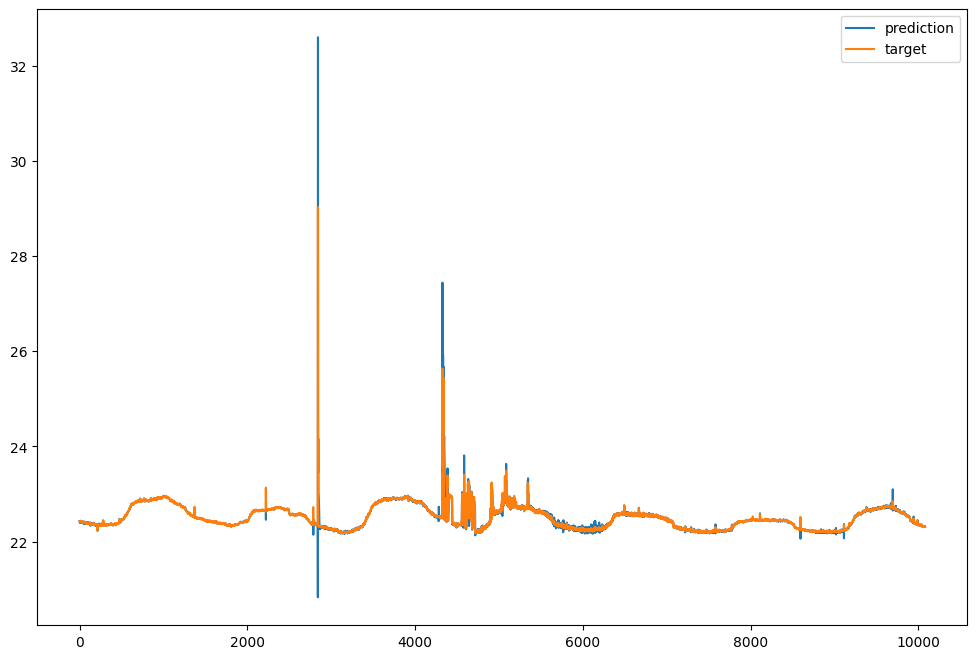

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

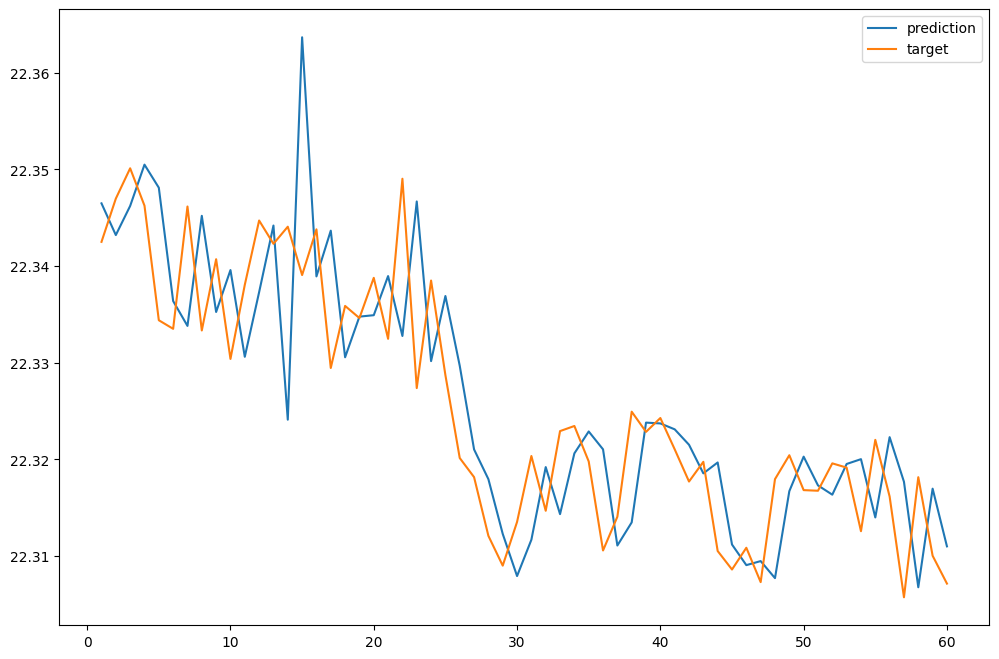

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [27]:
np.mean(time_list)

0.8162654818523498

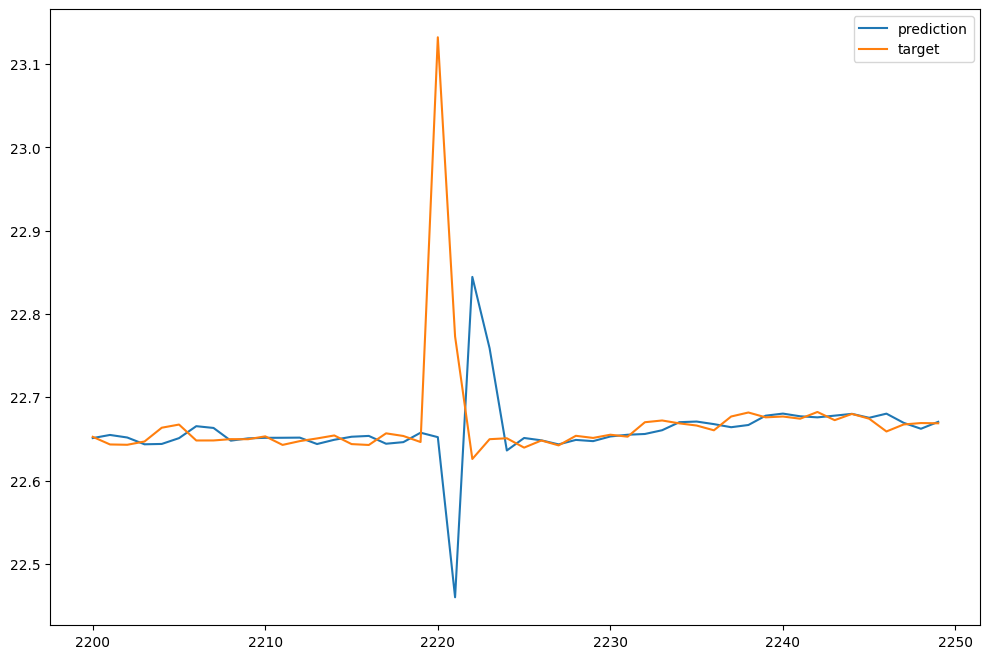

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()